# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses

In [2]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, KFold

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
# tracks = utils.load('data/fma_metadata/tracks.csv')
# genres = utils.load('data/fma_metadata/genres.csv')
# features = utils.load('data/fma_metadata/features.csv')
# echonest = utils.load('data/fma_metadata/echonest.csv')
# For Alice because she keeps her data in a different place :|
tracks = utils.load('/Volumes/GENRE_DATA/fma_metadata/tracks.csv')
genres = utils.load('/Volumes/GENRE_DATA/fma_metadata/genres.csv')
features = utils.load('/Volumes/GENRE_DATA/fma_metadata/features.csv')
echonest = utils.load('/Volumes/GENRE_DATA/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [4]:
# AUDIO_DIR = "data/fma_small"
#For alice
AUDIO_DIR = "/Volumes/GENRE_DATA/fma_small"

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [ ]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

In [ ]:
small['track'].groupby('genre_top').size()


In [ ]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

In [ ]:
genres.sort_values('#tracks').head(10)

## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [ ]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

### 3.1 Echonest features

In [ ]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

In [ ]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

In [ ]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [ ]:
## START BHAVNA SECTION
## FIX HOW WE ARE GETTING DATA!!! AXIS X IS TIME AND AXIS Y IS FREQUENCY SO DO NOT CUT OFF Y ANYMORE


In [5]:
small = tracks[tracks['set', 'subset'] <= 'small']
small = small.sample(frac=1)
small

album                                                     \
         comments        date_created date_released         engineer   
track_id                                                               
122901          0 2015-07-22 17:26:54           NaT   Hicham Chahidi   
121322          0 2015-06-12 20:38:35    2015-05-20              NaN   
61008           0 2012-02-26 10:39:05           NaT              NaN   
89816           4 2013-08-28 15:12:26    2013-08-28              NaN   
892             0 2008-11-26 02:26:21    2008-03-01    self-recorded   
...           ...                 ...           ...              ...   
111387          0 2014-11-28 14:24:13    2014-11-27              NaN   
123278          0 2015-08-03 11:55:47           NaT              NaN   
3765            0 2008-12-04 09:26:38    2003-04-22      Gil Shuster   
27673           5 2010-03-30 07:32:59           NaT              NaN   
68353           0 2012-07-27 12:06:37    2012-07-16  Justin Colletti   

                                                                              \
         favorites     id                                        information   
track_id                                                                       
122901           1  18597  <p>Copyright free world music featuring piano ...   
121322           1  18416  "Old demos dedicated to the life and art of La...   
61008            3  11161  <p></p><p>These tracks were originally release...   
89816            0  14961  <p>По сути Dreams это обычная танцевальная эле...   
892              0    246  <p><em>The Vertigo of Dawn</em> is Ilyas Ahmed...   
...            ...    ...                                                ...   
111387           0  17220                                                NaN   
123278           0  18648  <div class="tralbumData tralbum-about">\n<div ...   
3765             1    636  <p><span>The space-rock kings (and queen) of S...   
27673            8   5977                                                NaN   
68353            0  12210  <p>Possessing a maturity and musicality that b...   

                                  \
         listens        producer   
track_id                           
122901      2748  Hicham Chahidi   
121322     52406             NaN   
61008      17817             NaN   
89816      30947             NaN   
892         1945             NaN   
...          ...             ...   
111387     45062             NaN   
123278      6120             NaN   
3765       36737             NaN   
27673      19478             NaN   
68353       3605    Jesse Krakow   

                                                             ...       track  \
                                                       tags  ... information   
track_id                                                     ...               
122901                                                   []  ...         NaN   
121322                                                   []  ...         NaN   
61008             [orientalist, experimental, instrumental]  ...         NaN   
89816                                                    []  ...         NaN   
892                                                      []  ...         NaN   
...                                                     ...  ...         ...   
111387                                                   []  ...         NaN   
123278                                                   []  ...         NaN   
3765                                                     []  ...         NaN   
27673     [baroque trap, classical electronic, hip hop, ...  ...         NaN   
68353                                                    []  ...         NaN   

                                 \
         interest language_code   
track_id                          
122901       3495           NaN   
121322       6603           NaN   
61008        3994           NaN   
89816       14802           NaN   
892        

In [9]:
import warnings

audioData = small['track'][['genre_top']].head(100)

def create_standardized_table(input_table):
    input_table['filename'] = input_table.apply(lambda row : utils.get_audio_path(AUDIO_DIR, row.name), axis = 1) 
    input_table['xsr'] = input_table.apply(lambda row: librosa.load(row['filename'], sr=None, mono=True, duration = 30), axis = 1)
    input_table['stft'] = input_table.apply(lambda row: np.abs(librosa.stft(row['xsr'][0], n_fft=2048, hop_length=512)), axis = 1)
    input_table['mel_spect'] = input_table.apply(lambda row: librosa.feature.melspectrogram(sr=row['xsr'][1], S=row['stft']**2), axis = 1)
    input_table['mel_log'] = input_table.apply(lambda row: librosa.amplitude_to_db(row['mel_spect']), axis = 1)
    input_table['max_frequency'] = input_table.apply(lambda row: row['mel_log'].shape[1], axis = 1)
    frequency_cutoff = np.percentile(input_table['max_frequency'], 75, interpolation = 'nearest')
#     print("0",input_table.shape, frequency_cutoff)
#     print(input_table['max_frequency'])
    input_table = input_table[input_table['max_frequency'] <= frequency_cutoff]
#     print("1",input_table.shape, frequency_cutoff)
    input_table['mel_log_consistent_size'] = input_table.apply(lambda row: row['mel_log'][:, 0:frequency_cutoff], axis = 1)
#     print("2",input_table.shape)
    #normalizing so that every song is put in ranges of -1 to 1
    # TODO: Maybe change to just getting mean of every individual song
    input_table['mel_log_normalized'] = input_table.apply(lambda row: librosa.util.normalize(row['mel_log_consistent_size']), axis = 1)
#     print(input_table.shape)
    input_table['mel_log_normalized'] = input_table.apply(lambda row: row["mel_log_normalized"][:20,:], axis=1)
#     print(input_table.shape)
    input_table['mel_log_with_channel'] = input_table.apply(lambda row: np.reshape(row['mel_log_normalized'], row['mel_log_normalized'].shape + (1,)), axis = 1)

    return (input_table, frequency_cutoff)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (audioData, frequency_cutoff) = create_standardized_table(audioData)

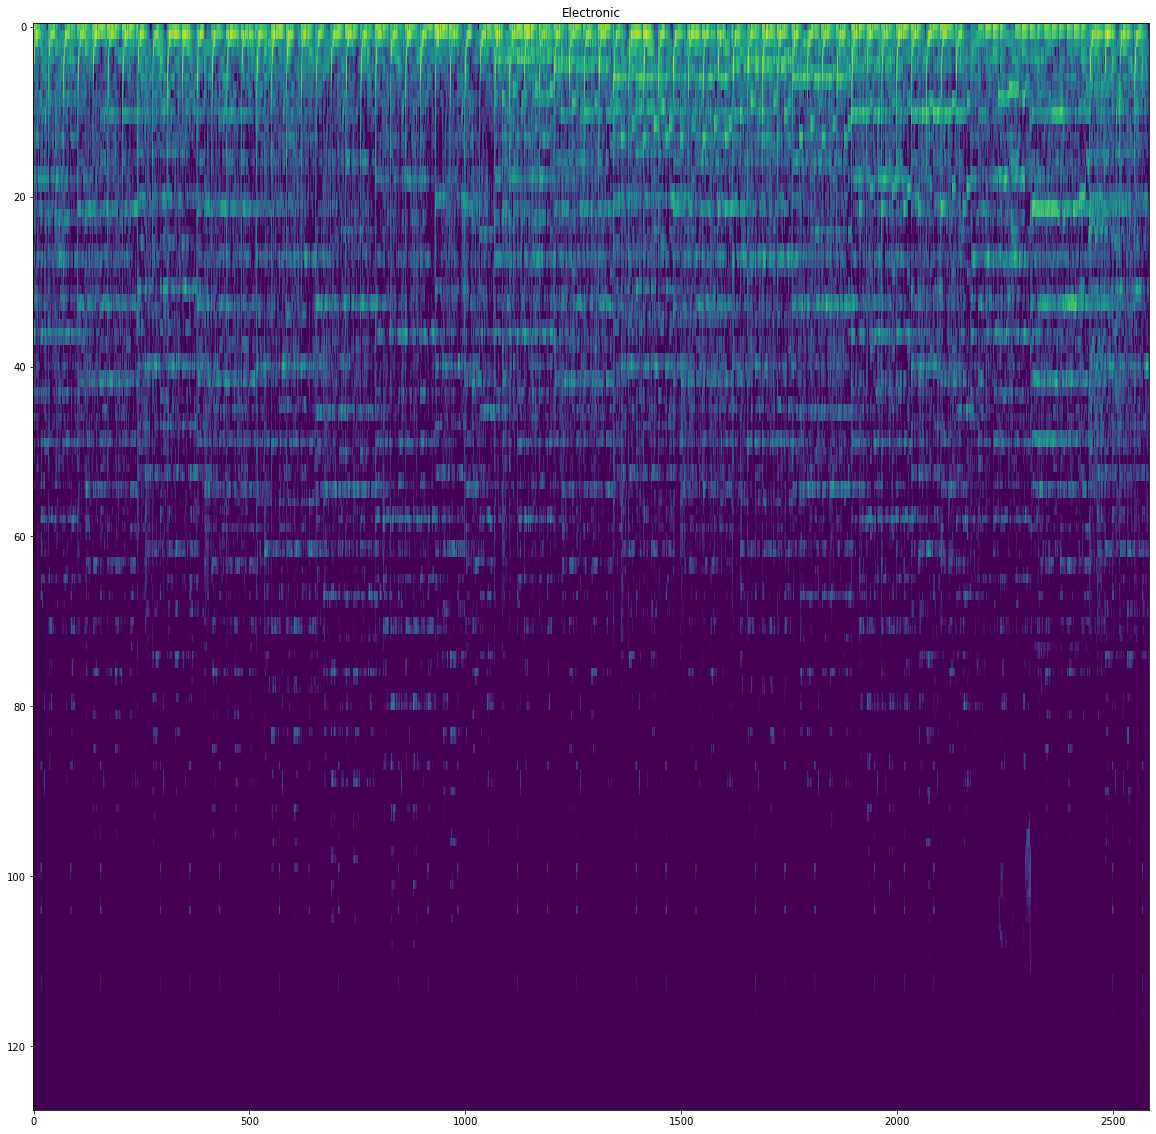

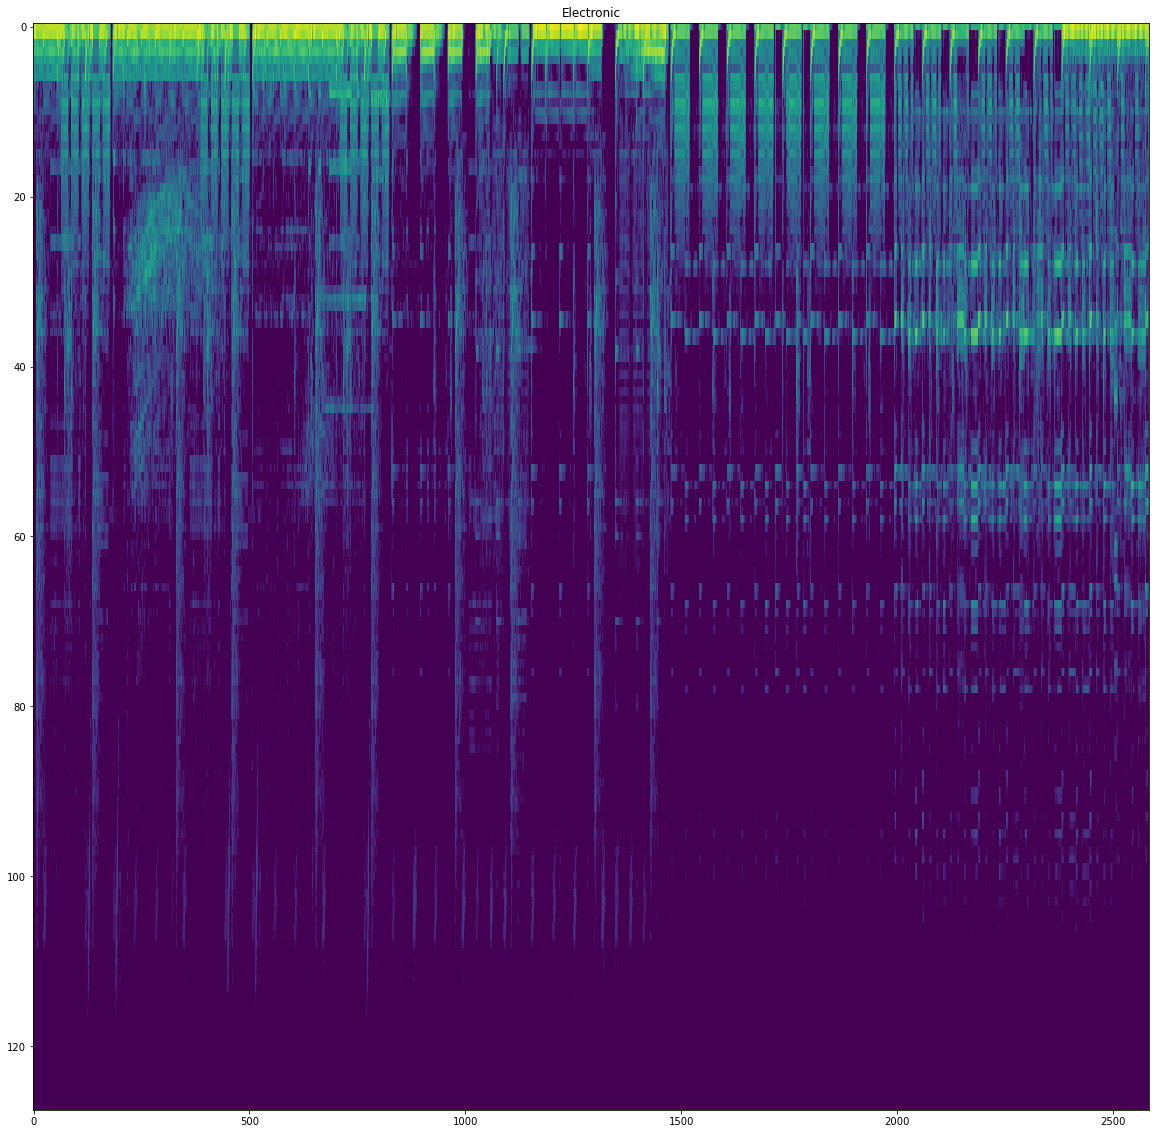

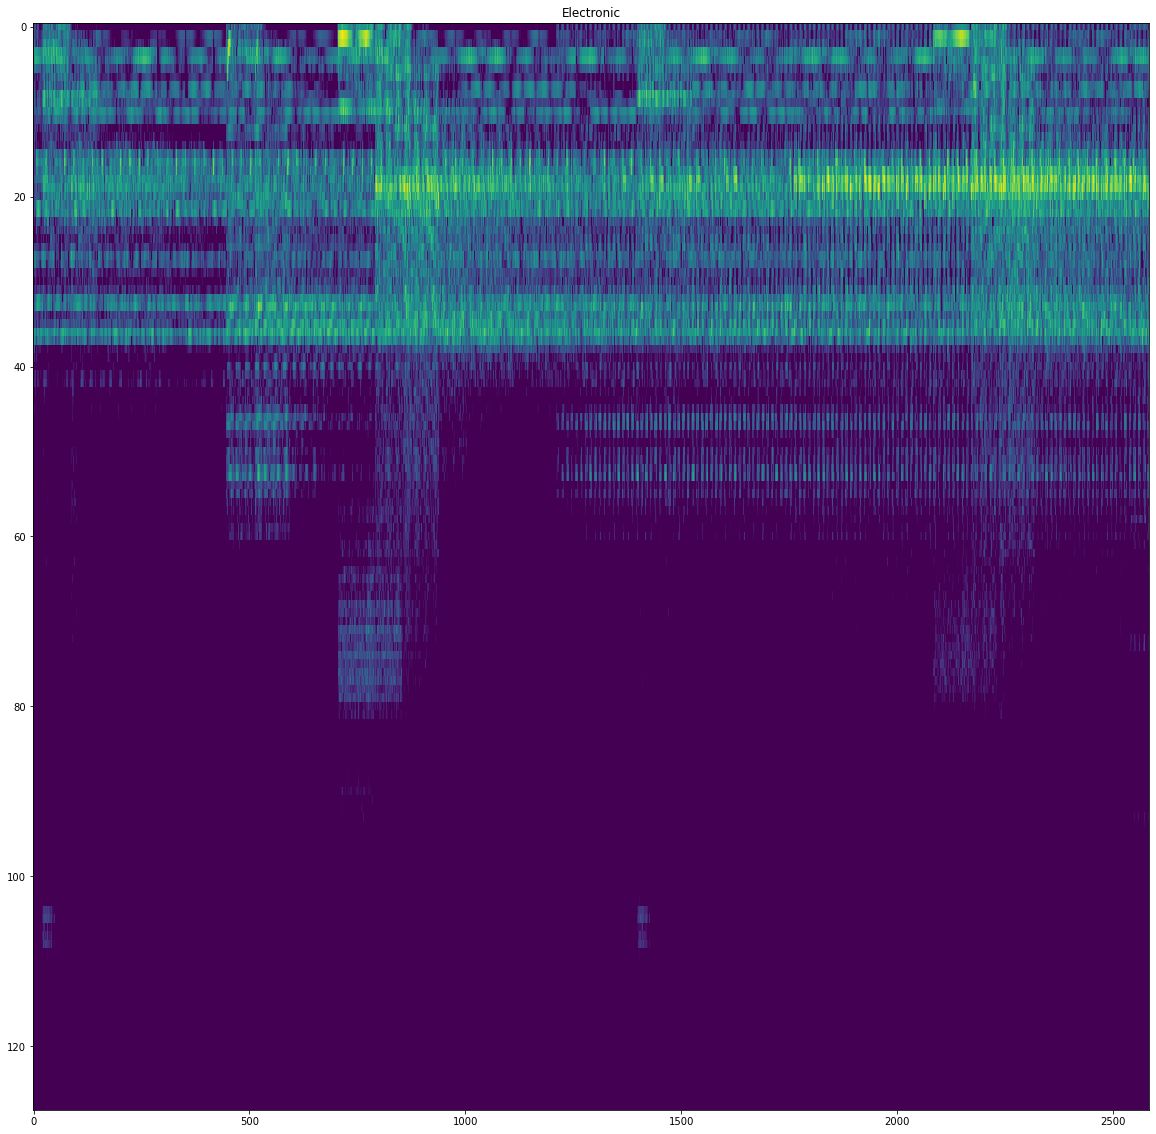

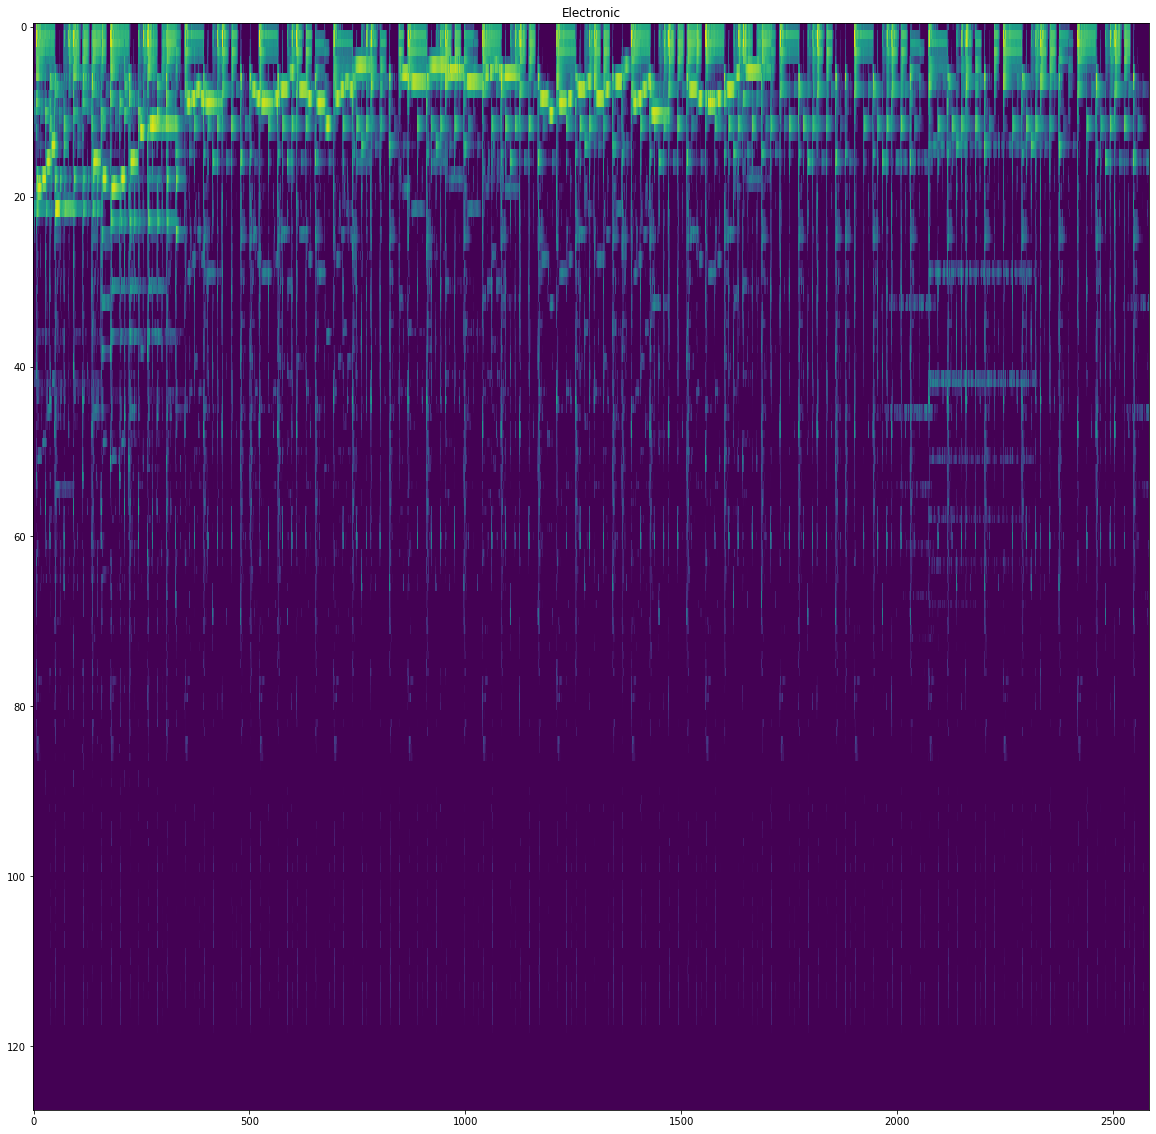

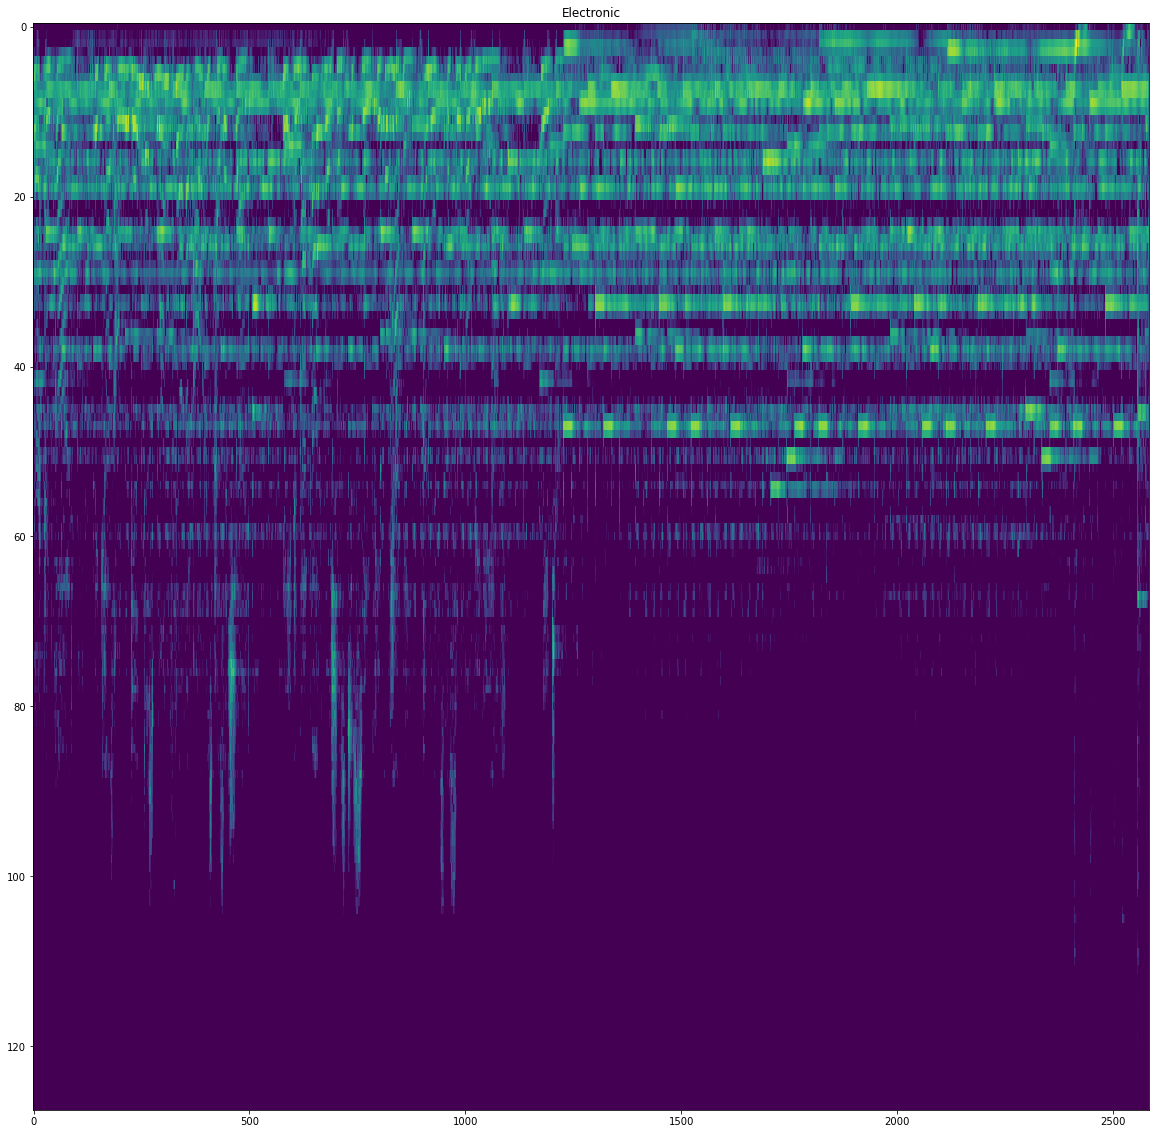

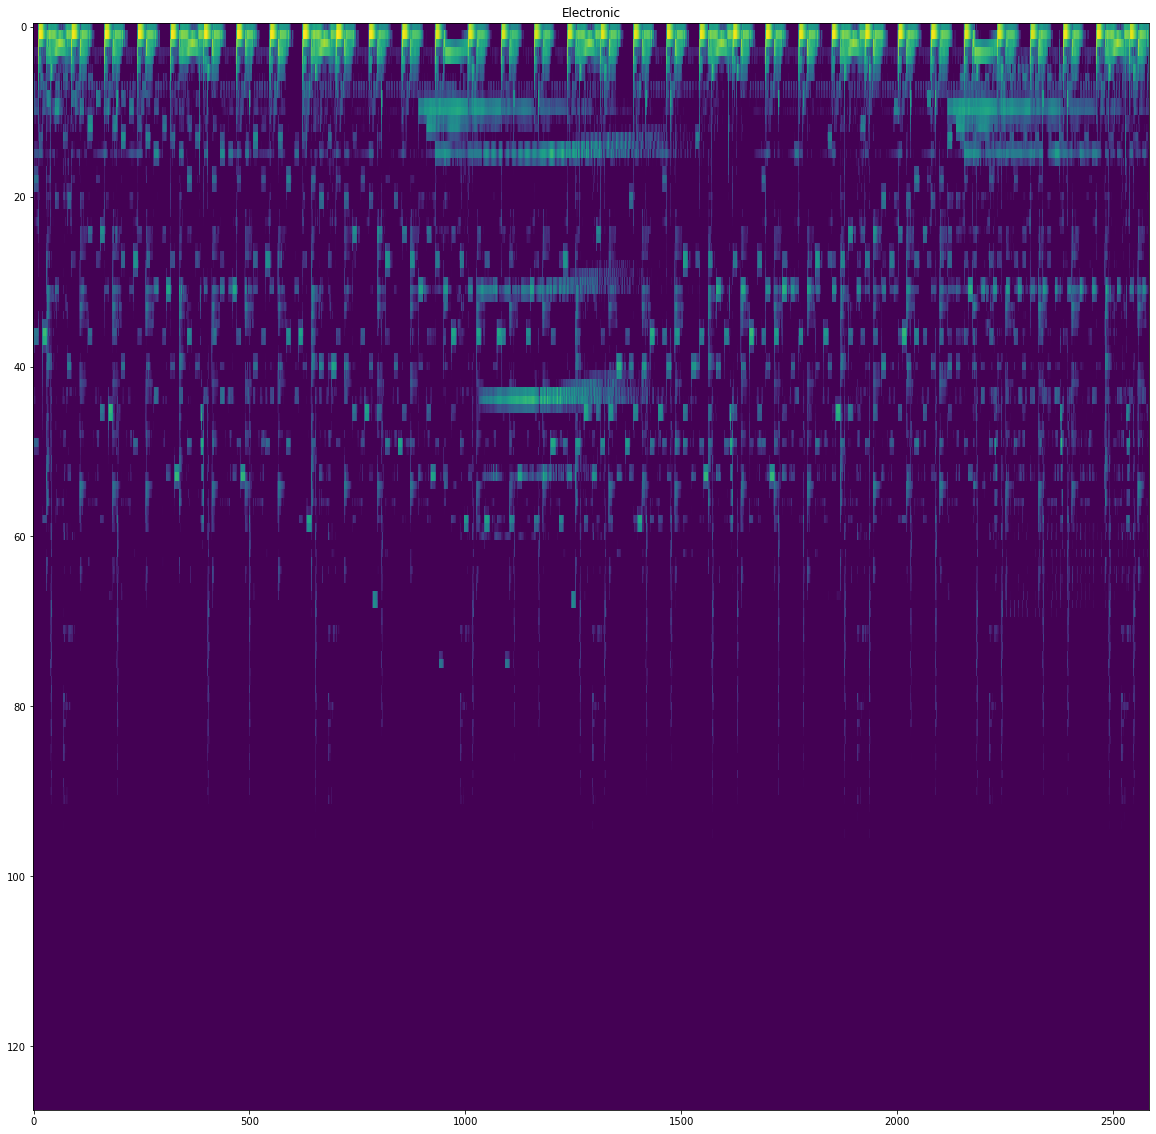

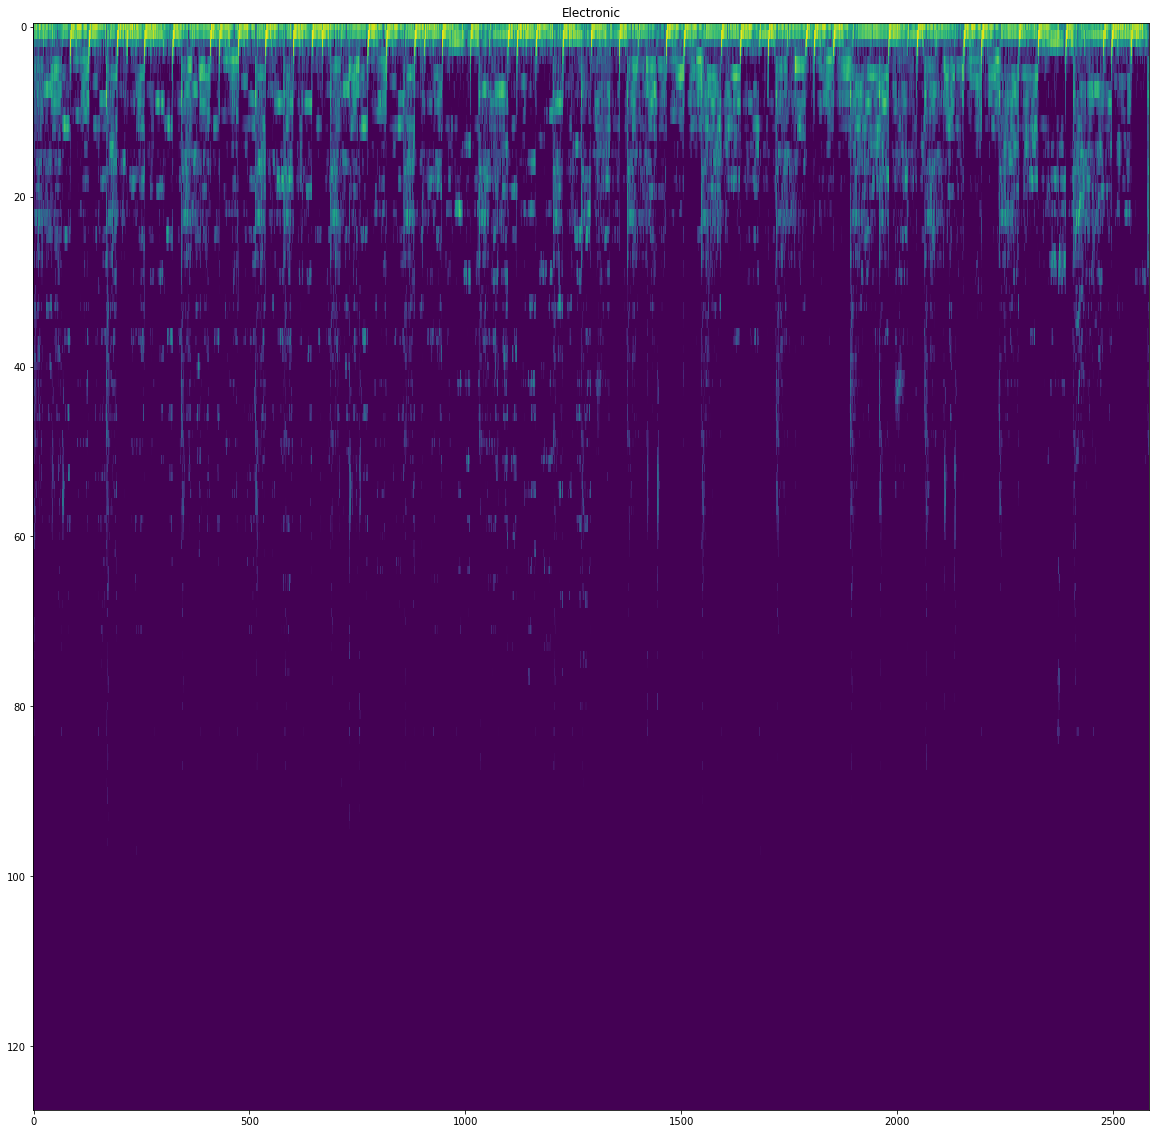

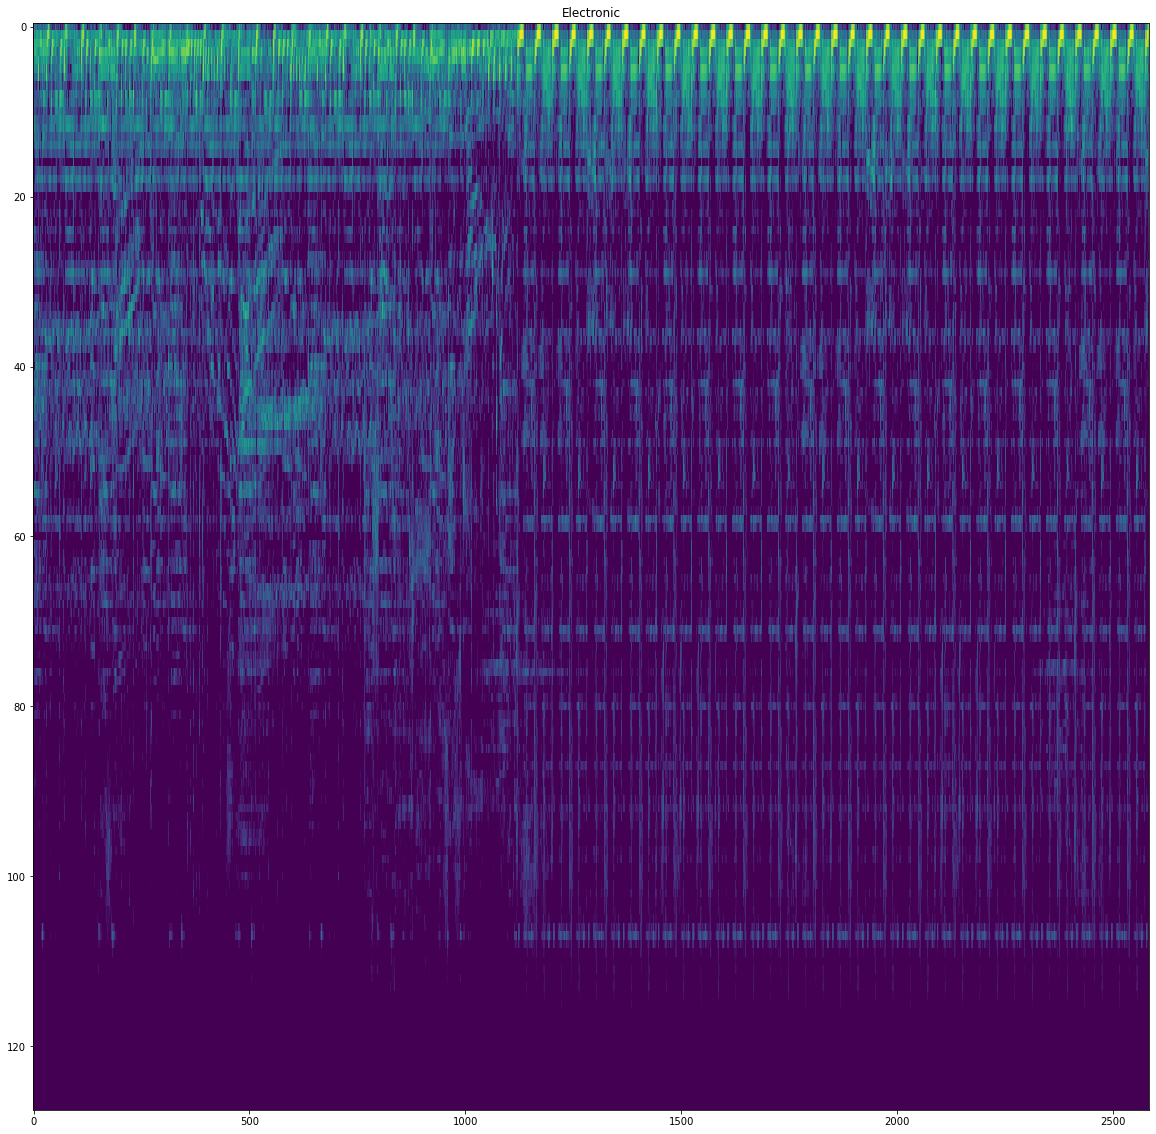

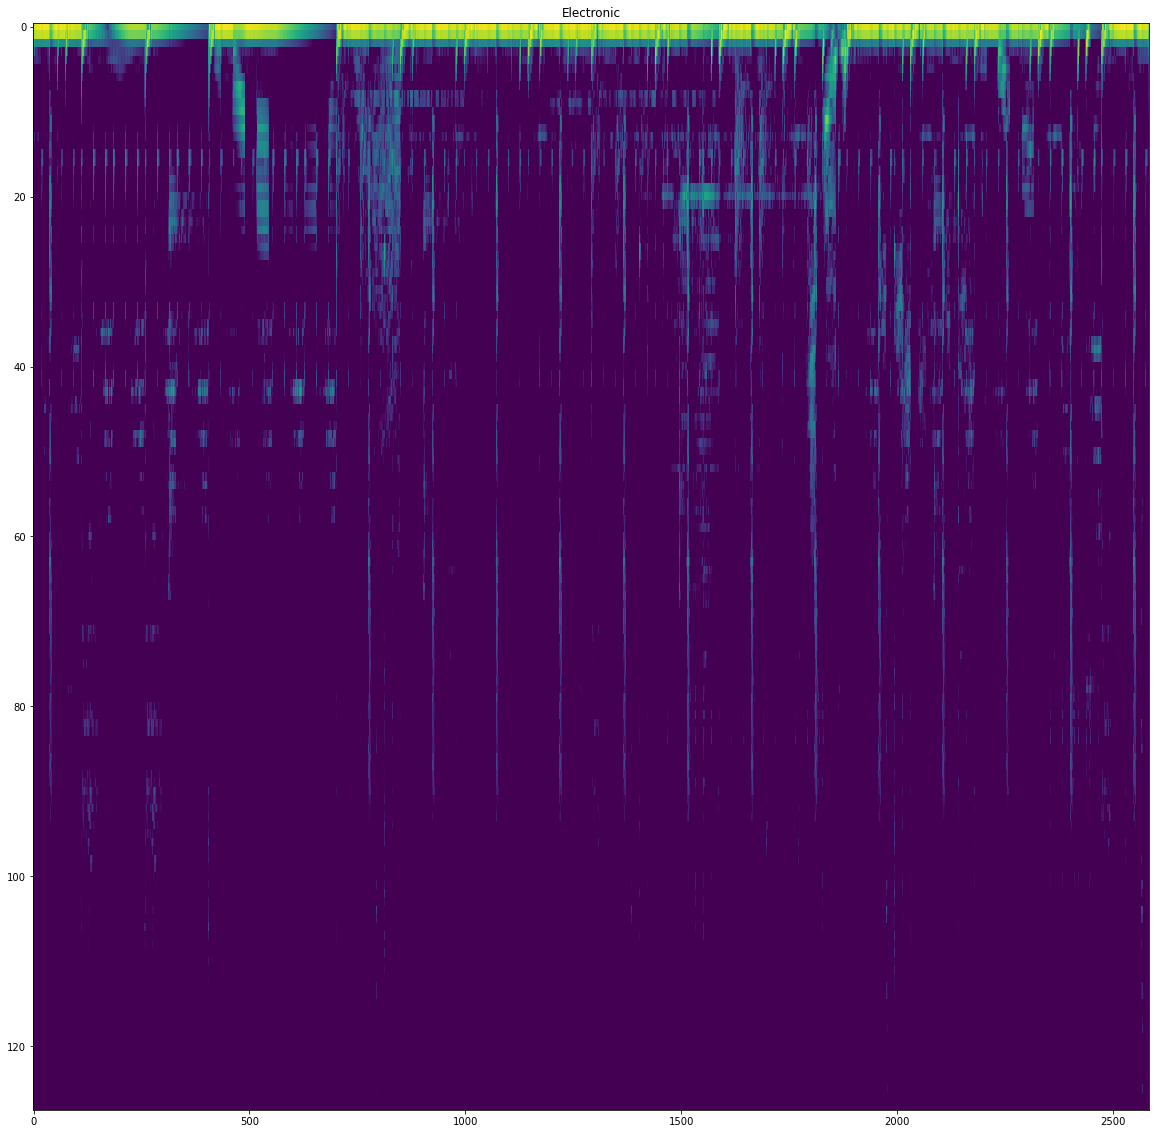

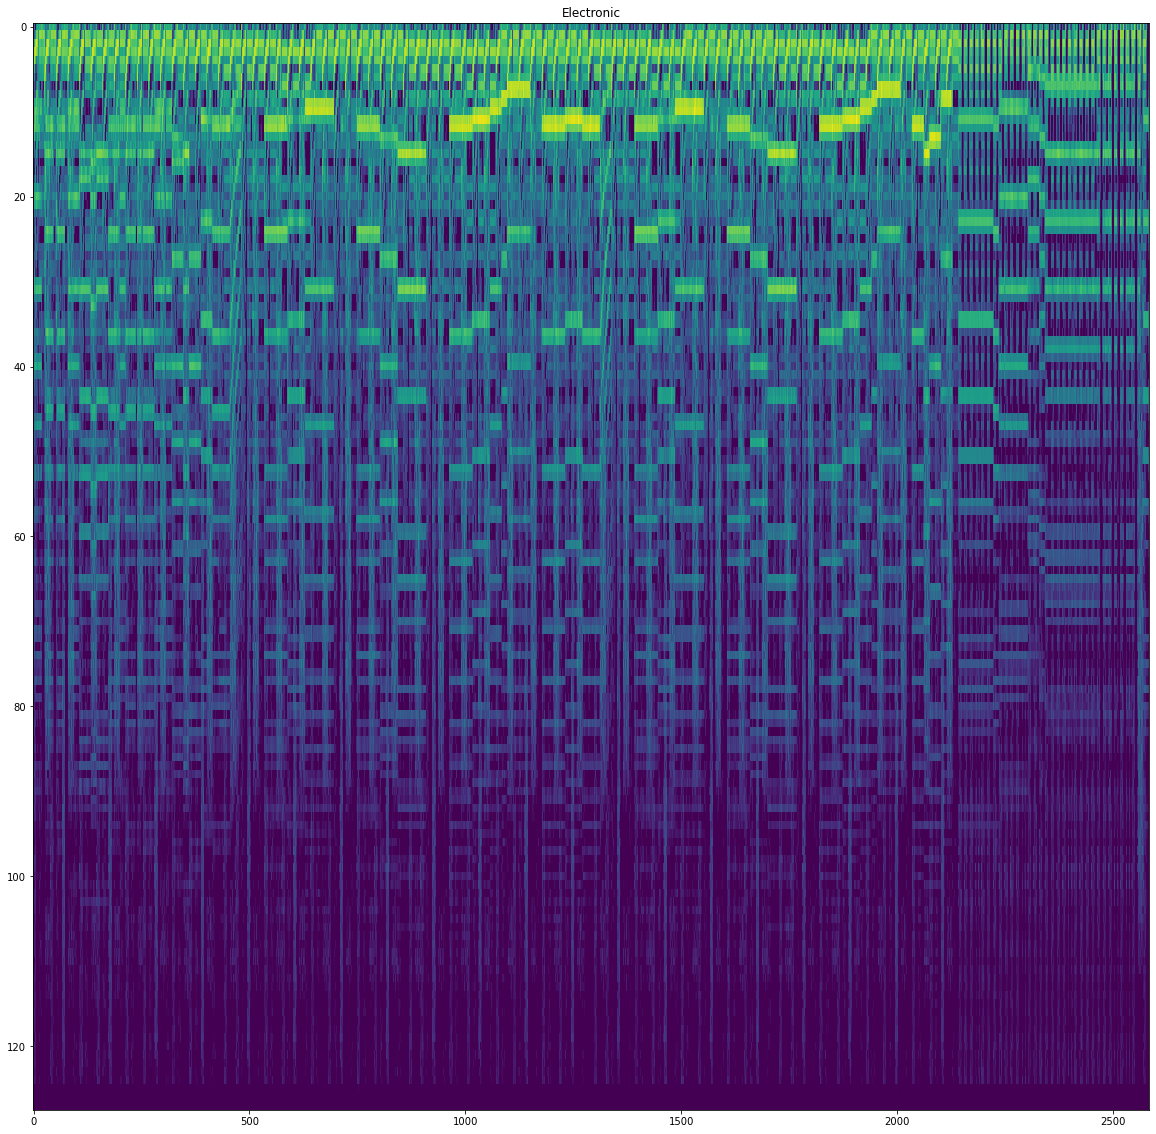

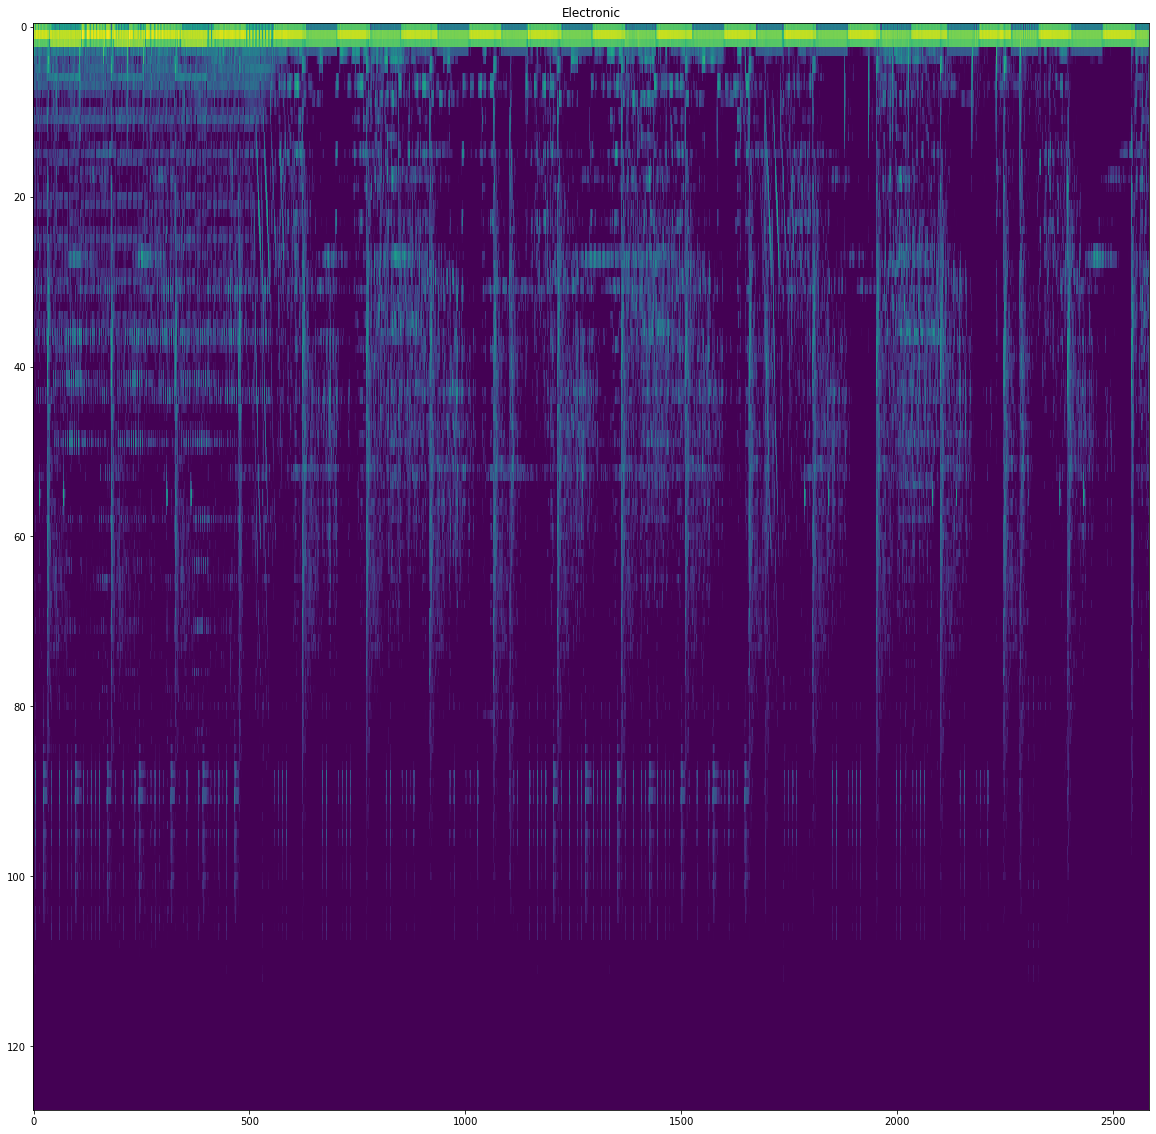

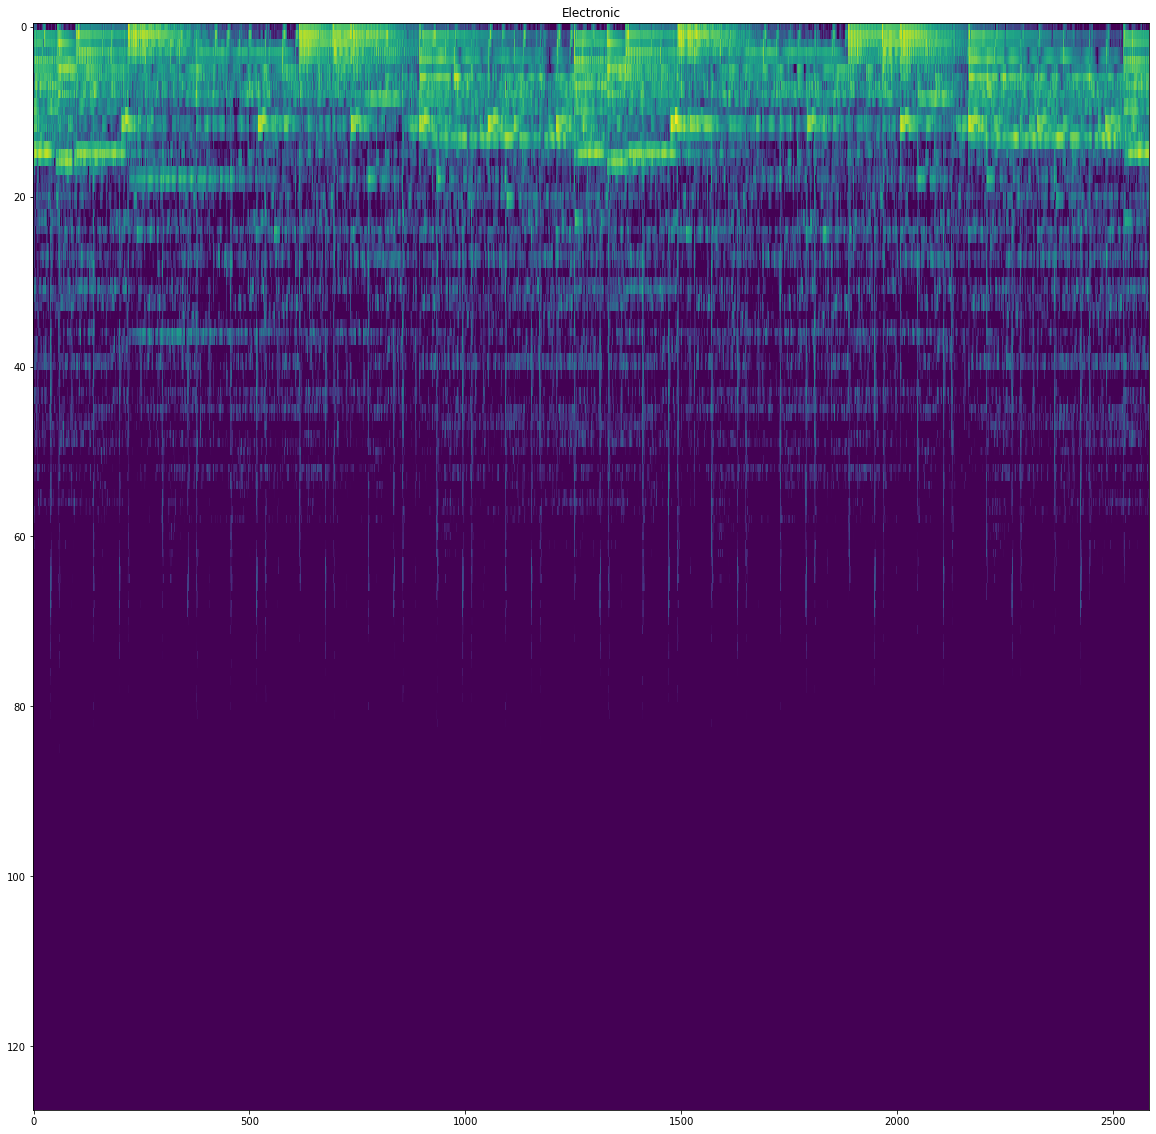

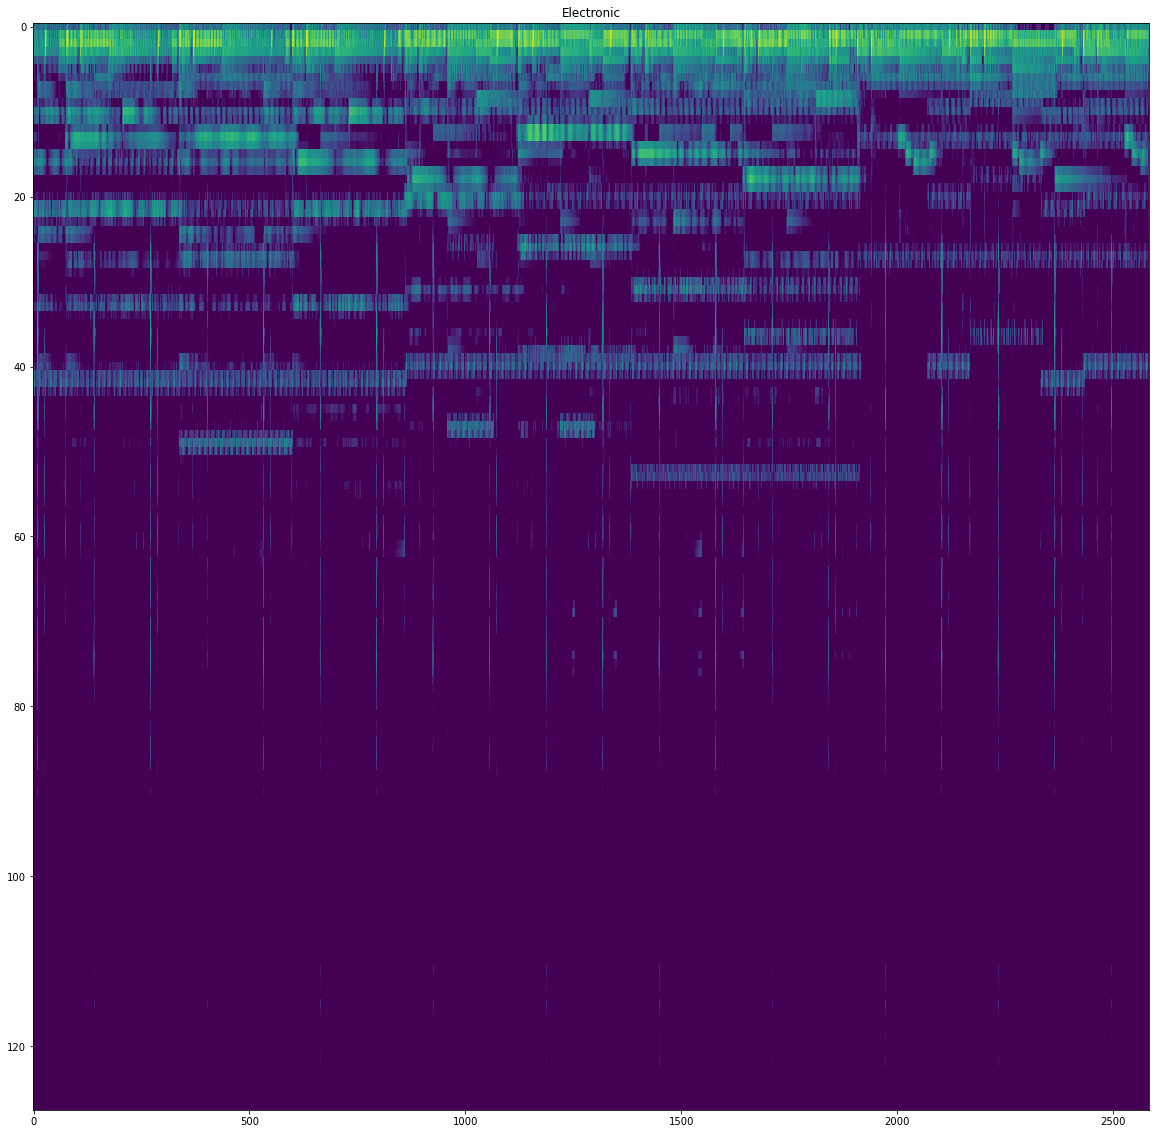

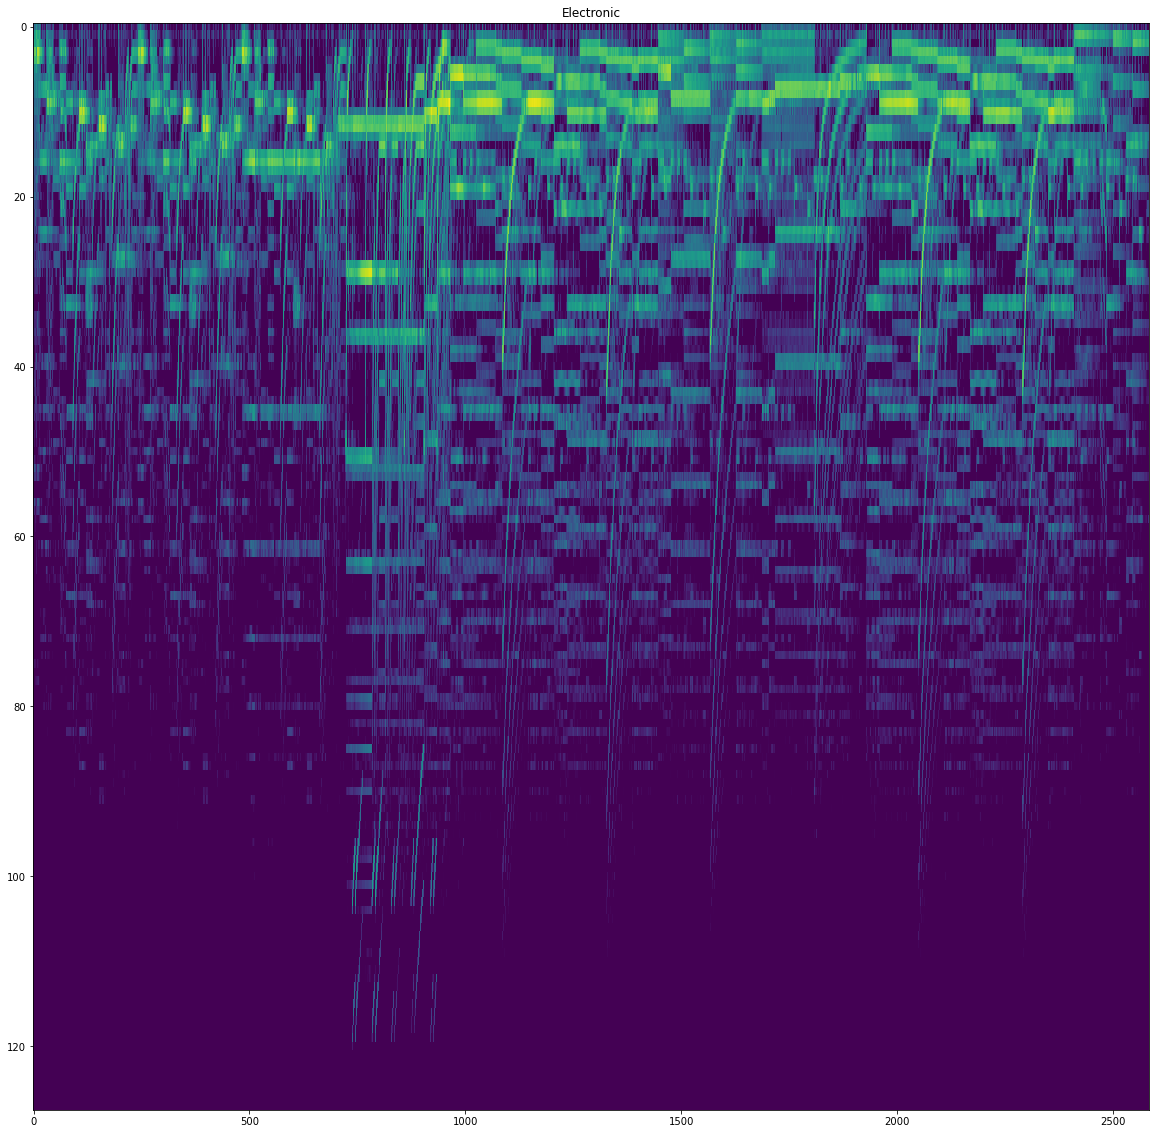

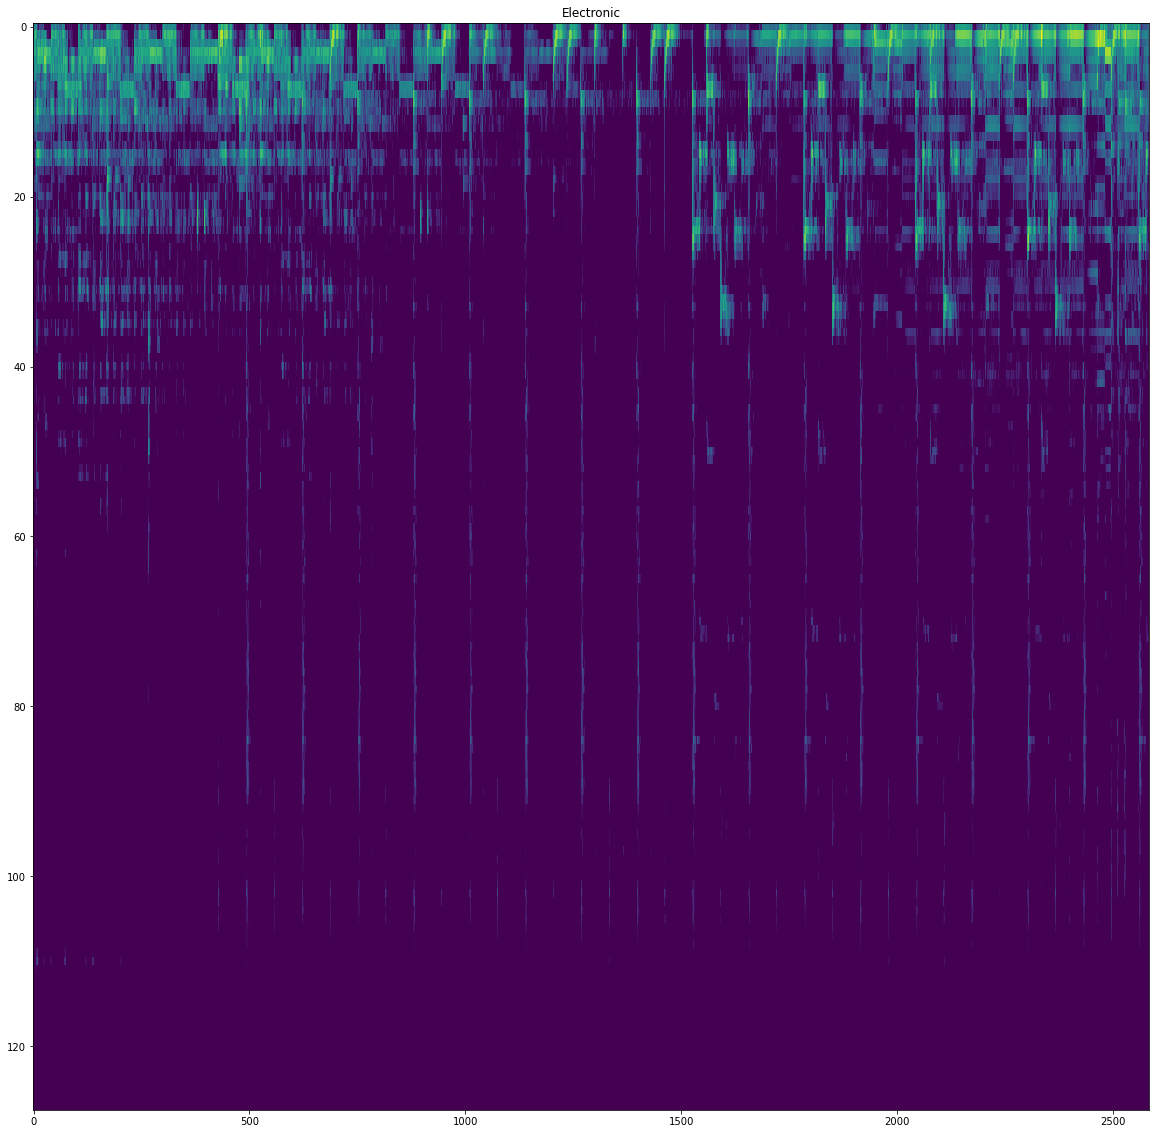

In [24]:
for i in range(len(audioData)):
    if audioData.iloc[i]["genre_top"] == "Electronic":
        plt.figure(i, figsize=(20,20))
        plt.imshow(audioData.iloc[i]["mel_log"], interpolation='nearest', aspect = "auto")
        plt.title(audioData.iloc[i]["genre_top"])
plt.show()

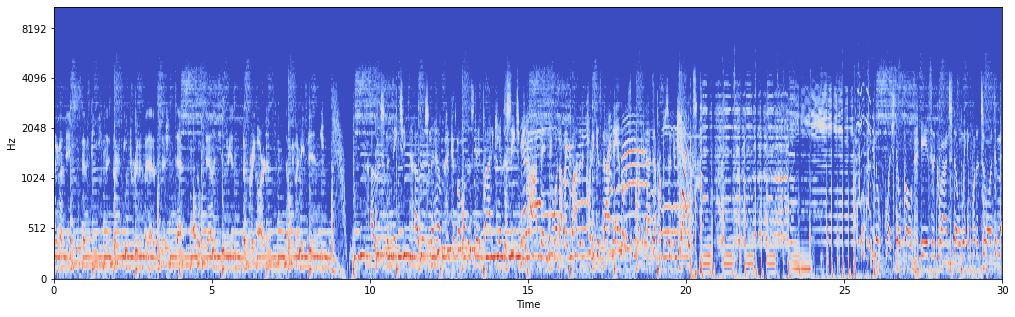

In [25]:
test = audioData.iloc[1]
librosa.display.specshow(test["mel_log"], sr=test["xsr"][1], hop_length=512, x_axis='time', y_axis='mel');

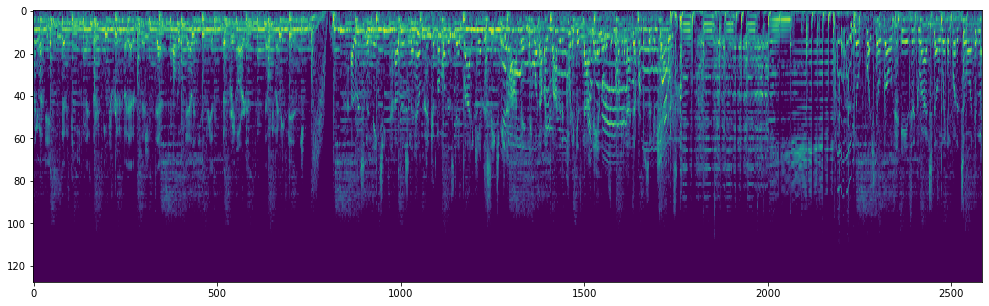

In [27]:
plt.imshow(test["mel_log"], interpolation='nearest', aspect = "auto")

In [22]:
#check if size is consistent
audioData['max_frequency_after_standardization'] = audioData.apply(lambda row: row['mel_log_normalized'].shape[1], axis = 1)
groupedByShape = audioData.groupby(audioData['max_frequency_after_standardization']).size()
groupedByShape
audioData[['genre_top']]

genre_top
track_id               
2               Hip-Hop
5               Hip-Hop
10                  Pop
140                Folk
141                Folk
148        Experimental
182                Rock
190                Folk
193                Folk
194                Folk
197                Folk
200                Folk
203                Folk
204                Folk
207                Folk
210                Folk
211                Folk
212                Folk
213                 Pop
255                Rock
256                Rock
368                Rock
424        Experimental
459                Rock
534                Folk
540                Folk
546                Folk
574                Rock
602                Folk
615        Experimental
...                 ...
3906               Folk
3908               Folk
3909               Folk
3910               Folk
3911               Folk
3912               Folk
3913               Folk
3920               Folk
3921               Folk
3950               Rock
4013               Folk
4017               Folk
4022               Rock
4037               Folk
4066               Folk
4067               Folk
4068               Folk
4069               Folk
4070      International
4071      International
4072      International
4073      International
4074      International
4075      International
4076      International
4077      International
4078      International
4079      International
4080      International
4091      International

[196 rows x 1 columns]

In [23]:
audioData['mel_log_normalized'].iloc[0].shape

(20, 2584)

In [10]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(audioData.drop('genre_top', inplace=False, axis = 1), audioData['genre_top'], test_size=0.25, random_state=24)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=24)

In [26]:
X_test.shape

(49, 10)

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(120, (4,4), activation='relu', padding = 'same', input_shape=(10, frequency_cutoff, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=0.1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=0.1)))
model.add(layers.Dense(8, use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=0.1)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 2584, 120)     2040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 1292, 120)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 1290, 64)       69184     
_________________________________________________________________
flatten_2 (Flatten)          (None, 247680)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                15851584  
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 15,923,328
Trainable params: 15,923,328
Non-trainable params: 0
__________________________________________

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(300, (2,2), activation='relu', padding = 'same', input_shape=(20, frequency_cutoff, 1)))
model.add(layers.Dropout(.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True))
model.add(layers.Dropout(.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', use_bias = True))
model.add(layers.Dense(8, use_bias = True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 2584, 300)     1500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 2584, 300)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 1292, 300)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 1290, 64)       172864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 1290, 64)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 645, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 643, 64)       

In [35]:
np.stack(X_train['mel_log_with_channel']).shape

(73, 20, 2584, 1)

In [14]:
label_dict = {
 'Electronic': 0,
 'Experimental': 1,
 'Folk': 2,
 'Hip-Hop': 3,
 'Instrumental': 4,
 'International': 5,
 'Pop': 6,
 'Rock': 7
}
Y_train = Y_train.replace(label_dict)
Y_val = Y_val.replace(label_dict)
Y_test = Y_test.replace(label_dict)

In [15]:
Y_train, Y_val

(track_id
 3264    2
 140     2
 3840    7
 1482    0
 1686    5
        ..
 203     2
 3920    2
 2096    1
 193     2
 1195    2
 Name: genre_top, Length: 73, dtype: int64,
 track_id
 4022    7
 892     2
 3911    2
 1510    1
 3724    7
        ..
 3895    5
 690     7
 694     3
 1733    1
 704     5
 Name: genre_top, Length: 74, dtype: int64)

In [65]:
type(Y_train)

pandas.core.series.Series

In [84]:
#cross validation to find best regularization parameters
fold_no = 1
k_fold = KFold(n_splits=15)
for train_indices, test_indices in k_fold.split(X_train):
    reg_param = 0.00015 * fold_no
    model = models.Sequential()
    model.add(layers.Conv2D(120, (4,4), activation='relu', padding = 'same', input_shape=(10, frequency_cutoff, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
    model.add(layers.Dense(8, use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
    model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history = model.fit(np.stack(X_train.iloc[train_indices]['mel_log_with_channel']), np.asarray(Y_train.iloc[train_indices]), epochs=5)
    scores = model.evaluate(np.stack(X_train.iloc[test_indices]['mel_log_with_channel']), np.asarray(Y_train.iloc[test_indices]), verbose=0)
    print(f'Score for fold {fold_no} with reg_param {reg_param}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    fold_no = fold_no + 1


Train on 387 samples
Epoch 1/5
387/387 [==============================] - 44s 115ms/sample - loss: 2.6879 - accuracy: 0.1421
Epoch 2/5
387/387 [==============================] - 30s 78ms/sample - loss: 1.9795 - accuracy: 0.2997
Epoch 3/5
387/387 [==============================] - 28s 72ms/sample - loss: 1.9230 - accuracy: 0.3773
Epoch 4/5
387/387 [==============================] - 28s 71ms/sample - loss: 1.7725 - accuracy: 0.4083
Epoch 5/5
387/387 [==============================] - 33s 86ms/sample - loss: 1.6188 - accuracy: 0.4729
Score for fold 1 with reg_param 0.00015: loss of 1.937320351600647; accuracy of 32.14285671710968%
Train on 387 samples
Epoch 1/5
387/387 [==============================] - 34s 88ms/sample - loss: 2.9083 - accuracy: 0.2403
Epoch 2/5
387/387 [==============================] - 27s 71ms/sample - loss: 2.0606 - accuracy: 0.2636
Epoch 3/5
387/387 [==============================] - 27s 70ms/sample - loss: 1.9688 - accuracy: 0.2972
Epoch 4/5
387/387 [===============

In [16]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(np.stack(X_train['mel_log_with_channel']), np.asarray(Y_train), epochs=10, 
                validation_data=(np.stack(X_val['mel_log_with_channel']), np.asarray(Y_val)))

Train on 73 samples, validate on 74 samples
Epoch 1/10
73/73 [==============================] - 1256s 17s/sample - loss: 2.1414 - accuracy: 0.2603 - val_loss: 1.8910 - val_accuracy: 0.2162
Epoch 2/10
73/73 [==============================] - 5199s 71s/sample - loss: 2.0719 - accuracy: 0.2329


KeyboardInterrupt: 

In [40]:
Y_val.value_counts()[2]/len(Y_val)

0.3783783783783784

In [55]:
#see which ones it's predicting wrong
val_predictions = model.predict(np.stack(X_val['mel_log_with_channel']))
predictions = []
two_count = 0
for arr in val_predictions:
    predictions.append(np.argmax(arr))
predictions

[1,
 1,
 5,
 2,
 1,
 2,
 2,
 1,
 5,
 2,
 5,
 5,
 5,
 5,
 2,
 2,
 2,
 1,
 1,
 5,
 1,
 5,
 5,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 2,
 5,
 2,
 5,
 2,
 5,
 1,
 2,
 5,
 5,
 2,
 5,
 2,
 1,
 2,
 2,
 1,
 5,
 2,
 2,
 2,
 5,
 1,
 2,
 1,
 5,
 1,
 2,
 2,
 2,
 5,
 5,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 5,
 2,
 1,
 5]

In [62]:
correctness_arr = [0, 0, 0, 0, 0, 0, 0, 0]
for x in range(0, len(predictions)):
    if predictions[x] == Y_val.iloc[x]:
        correctness_arr[predictions[x]] += 1
for y in range(0, 8):
    if y in Y_val.value_counts():
        correctness_arr[y] = correctness_arr[y]/Y_val.value_counts()[y]
    
correctness_arr
    

[0,
 0.3333333333333333,
 0.5357142857142857,
 0.0,
 0,
 0.35714285714285715,
 0.0,
 0.0]

In [125]:
## DONE WITH BHAVNA SECTION

In [127]:
filename = utils.get_audio_path(AUDIO_DIR, 10)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: data/fma_small/000/000010.mp3


/Users/bhavnasud/.local/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Duration: 29.99s, 1322496 samples


And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

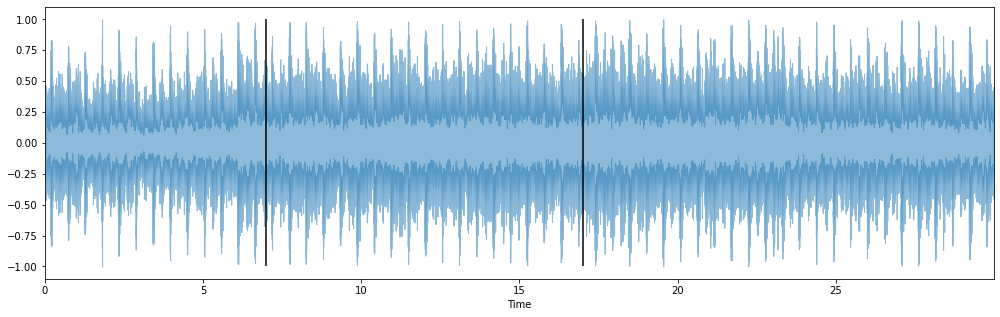

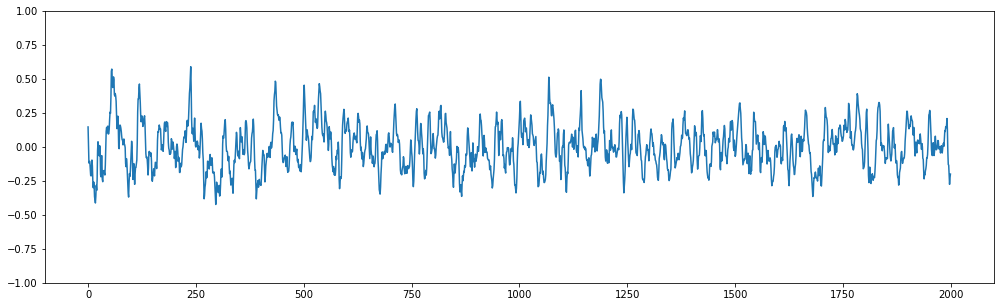

In [20]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

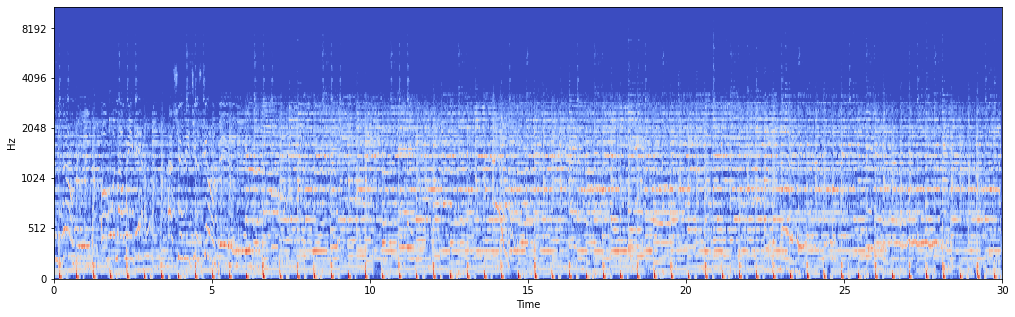

In [22]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

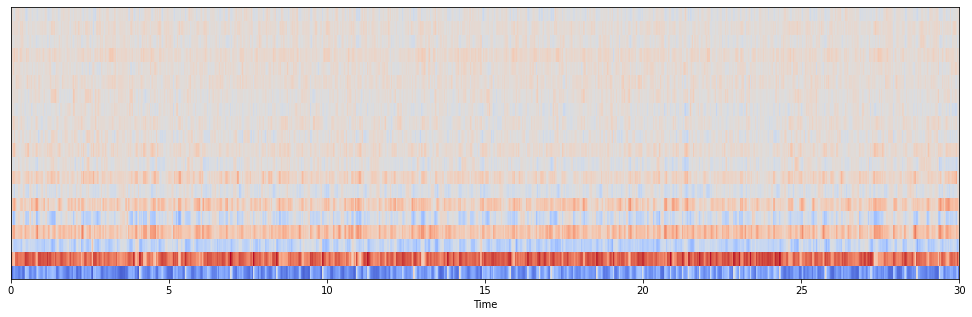

In [16]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

## 5 Genre classification

### 5.1 From features

In [17]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [18]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


### 5.2 From audio